TensorFlow 1.x selected.
Mounted at /content/drive
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
train_accuracy is  0.98
valid_accuracy is  0.99
test_accuracy is  0.9793103448275862


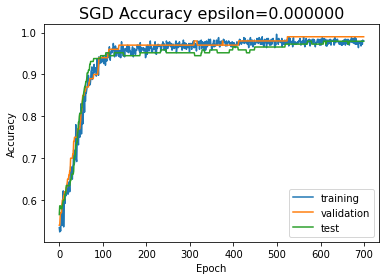

train_accuracy is  0.978
valid_accuracy is  0.97
test_accuracy is  0.9586206896551724


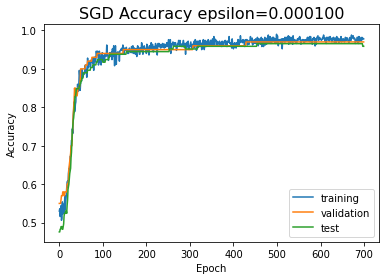

In [1]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
Data_file = '/content/drive/MyDrive/Colab Notebooks/notMNIST.npz'

def loadData():
    with np.load(Data_file) as dataset:
        Data, Target = dataset['images'], dataset['labels']
        posClass = 2
        negClass = 9
        dataIndx = (Target==posClass) + (Target==negClass)
        Data = Data[dataIndx]/255.
        Target = Target[dataIndx].reshape(-1, 1)
        Target[Target==posClass] = 1
        Target[Target==negClass] = 0
        np.random.seed(421)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data, Target = Data[randIndx], Target[randIndx]
        trainData, trainTarget = Data[:3500], Target[:3500]
        validData, validTarget = Data[3500:3600], Target[3500:3600]
        testData, testTarget = Data[3600:], Target[3600:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

def Process_Data():
    # 3500*28*28 100*28*28  145*28*28
    #[trainData, validData, testData, trainTarget, validTarget, testTarget]
    dataList = loadData()
    dataList = list(dataList)

    # 3500*784    100*784    145*784
    # [trainData, validData, testData]
    for i, data in enumerate(dataList[:3]):
        dataList[i] = data.reshape(len(data), -1)

    trainData  = dataList[0] #3500*784
    validData  = dataList[1] #100*784
    testData   = dataList[2] #145*784

    trainTarget= dataList[3].astype(int) #3500*1
    validTarget= dataList[4].astype(int) #100*1
    testTarget = dataList[5].astype(int) #145*1

    return trainData,validData,testData,trainTarget,validTarget,testTarget


# trainData,validData,testData,trainTarget,validTarget,testTarget = Process_Data()
# print(trainTarget)

def buildGraph(learning_rate, b1=None, b2=None, eps=None):
  
  #Initialize weight and bias tensor
  W = tf.Variable(tf.truncated_normal(shape=(784, 1), mean=0.0, stddev=0.5, dtype=tf.float32, seed =None, name=None))
  b = tf.Variable(tf.zeros(1))

  #Place holder for Data, Label, regularization parameter
  x = tf.placeholder(tf.float32, shape=(None, 784))
  y = tf.placeholder(tf.float32, shape=(None, 1))
  reg = tf.placeholder(tf.float32, shape=None)

  #The loss tensor
  z = tf.matmul(x,W)+b
  y_hat = tf.nn.sigmoid(z)
  lce = tf.losses.sigmoid_cross_entropy(y, y_hat)
  lw = reg/2.0 * tf.nn.l2_loss(W)
  loss = lce + lw
  

  #Adam optimizer
  '''
  tf.compat.v1.train.AdamOptimizer(
    learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-08, use_locking=False,
    name='Adam')
  '''
  if(b1):
    optimizer = tf.train.AdamOptimizer(learning_rate,beta1=b1).minimize(loss)
  elif(b2):
    optimizer = tf.train.AdamOptimizer(learning_rate,beta2=b2).minimize(loss)
  elif(eps):
    optimizer = tf.train.AdamOptimizer(learning_rate,epsilon=eps).minimize(loss)
  else:
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

  #The function should return the TensorFlow objects for 
  #weight, bias, predicted labels, real labels, the loss, and the optimizer.
  return W, b, x, y, y_hat, loss, optimizer, reg

def plot_loss(train, valid, learning_rate, batch):
  print("train_loss is ", train[-1])
  print("valid_loss is ", valid[-1])
  iterations = range(len(train))
  plt.plot(iterations,train,label = "training")
  plt.plot(iterations,valid,label = "validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.title('SGD Loss learning_rate = %s batch =  %s' %(learning_rate, batch), fontsize=16)
  plt.show()
  return 

def plot_Accu(train, valid, learning_rate, batch):
  print("train_accuracy is ", train[-1])
  print("valid_accuracy is ", valid[-1])
  iterations = range(len(train))
  plt.plot(iterations,train,label = "training")
  plt.plot(iterations,valid,label = "validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.title('SGD Accuracy learning_rate = %s batch = %s' %(learning_rate, batch), fontsize=16)
  plt.show()
  return 

def plot_Accu_Adam(train, valid, test, Adam_Parameters):
  print("train_accuracy is ", train[-1])
  print("valid_accuracy is ", valid[-1])
  print("test_accuracy is ", test[-1])

  iterations = range(len(train))
  plt.plot(iterations,train,label = "training")
  plt.plot(iterations,valid,label = "validation")
  plt.plot(iterations,test,label = "test")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()

  if(Adam_Parameters[0]):
    plt.title('SGD Accuracy beta1=%f' %(Adam_Parameters[0]), fontsize=16)
  elif(Adam_Parameters[1]):
    plt.title('SGD Accuracy beta2=%f' %(Adam_Parameters[1]), fontsize=16)
  else:
    plt.title('SGD Accuracy epsilon=%f' %(Adam_Parameters[2]), fontsize=16)
  plt.show()
  return 

def random_shuffle(trainData,trainTarget):
  # randomly shuffle traindata, trainTarget
  order = np.random.permutation(len(trainTarget))
  #print("trainData shape",trainData.shape)
  return trainData[order], trainTarget[order]

                       # Adam_Parameters beta1=None, beta2=None, epsilon=None
def SGD(epochs, batch_size, learning_rate, Adam_Parameters = None):

  #========================== Load and Proccess Data ===============================#
  # trainData, trainTarget, validData, validTarget, testData, testTarget = loader()
  # trainData = trainData.reshape((trainData.shape[0], trainData.shape[1]*trainData.shape[2]))
  # validData = validData.reshape((-1,validData.shape[1]*validData.shape[2]))
  # testData = testData.reshape((-1,testData.shape[1]*testData.shape[2]))

  #3500*784 100*784 145*784  3500*1  100*1    145*1
  trainData,validData,testData,trainTarget,validTarget,testTarget = Process_Data() 

  # build graph
  if (Adam_Parameters == None):
    W, b, x, y, y_hat, loss, optimizer, reg = buildGraph(learning_rate)
  else:
    W, b, x, y, y_hat, loss, optimizer, reg = buildGraph(learning_rate,Adam_Parameters[0],Adam_Parameters[1],Adam_Parameters[2])

  #Variables to be calculated
  regularization_parameter = 0
  train_loss, valid_loss = [],[]
  train_accur, valid_accur = [],[]
  test_loss, test_accur = [],[]
  n_batch = int(len(trainTarget)/batch_size)
  # start training
  with tf.Session() as ssess:
    ssess.run(tf.global_variables_initializer())
    for i in range(epochs):
      trainData,trainTarget = random_shuffle(trainData,trainTarget)


      # ========================= train model from selected 1 batch
      # Training Data Divide into batch
      batch_X = trainData[0 : batch_size]
      batch_Y =  trainTarget[0 : batch_size]
      new_y_hat, new_loss, new_y, op = ssess.run([y_hat, loss, y, optimizer], 
                              feed_dict={ x: batch_X, 
                                    y: batch_Y, 
                                    reg: regularization_parameter})   
      #calculate training acuuracy
      train_a = np.sum((new_y_hat>0.5)==new_y)/batch_size#accuracy
      train_loss.append(new_loss)
      train_accur.append(train_a)


      #=================================== Validation Data ======================================#
      Valid_predic, Valid_loss, new_y = ssess.run([y_hat, loss, y], 
                          feed_dict={x: validData, 
                                y: validTarget, 
                                reg: regularization_parameter})
      valid_loss.append(Valid_loss)
      valid_accur.append(np.sum((Valid_predic>0.5)==new_y)/new_y.shape[0])

      #=================================== Validation Data ======================================#
      Test_predic, Test_loss, new_y = ssess.run([y_hat, loss, y], 
                          feed_dict={x: testData, 
                                y: testTarget, 
                                reg: regularization_parameter})
      test_loss.append(Test_loss)
      test_accur.append(np.sum((Test_predic>0.5)==new_y)/new_y.shape[0])

    #plot_loss(train_loss, valid_loss, learning_rate, batch_size)
    #plot_Accu(train_accur, valid_accur, learning_rate, batch_size)
    plot_Accu_Adam(train_accur, valid_accur, test_accur, Adam_Parameters)
  return train_loss, valid_loss, train_accur, valid_accur, test_accur

def Q2():
  epochs = 700
  batch_size = 500
  learning_rate = 0.001
  SGD(epochs, batch_size, learning_rate)
  return

#Q2()
def Batch_Size_Investigation():
  epochs = 700
  learning_rate = 0.001
  B = [100,700,1750]
  for batch_size in B:
    SGD(epochs, batch_size, learning_rate)
  return

#Batch_Size_Investigation()

def Hyperparameter_Investigation():
  epochs = 700
  batch_size = 500
  learning_rate = 0.001

  # beta1=None
  # beta2=None
  # epsilon=None
  # B1 = [0.95,0.99]
  # for beta1 in B1:
  #   Adam_Parameters = [beta1,beta2,epsilon]
  #   SGD(epochs, batch_size, learning_rate, Adam_Parameters)
  
  # beta1=None
  # beta2=None
  # epsilon=None
  # B2 = [0.99,0.9999]
  # for beta2 in B2:
  #   Adam_Parameters = [beta1,beta2,epsilon]
  #   SGD(epochs, batch_size, learning_rate, Adam_Parameters)

  beta1=None
  beta2=None
  epsilon=None
  E = [1e-9,1e-4]
  for epsilon in E:
    Adam_Parameters = [beta1,beta2,epsilon]
    SGD(epochs, batch_size, learning_rate, Adam_Parameters)
  return

Hyperparameter_Investigation()



# 新段落

# 新段落

# 新段落